Давайте попробуем поизучать сезонность торговых инстументов.
Возьмем, например, EURUSD
Экспортируем из метатрейдера дневной график, он там доступен с ноября 2002 года. 
В принципе, можно экспортировать любой ТФ, но для анализа сезонности нам должно быть достаточно дневных движений
Разметим колонки в файле, как DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOLUME - именно в таком порядке данные расположены в файле выдачи экспорта истории метатрейдера.
Давайте зачитаем его в табличку:

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('Dukascopy-GBPUSD-2003.05.04-2025.02.05-bardata_D1.csv',
                 sep=',',
                 header=0,
                 dtype={
                     'Open': np.float64,
                     'High': np.float64,
                     'Low': np.float64,
                     'Close': np.float64},
                 encoding='utf-8',
                 parse_dates=['Date'],
                 date_format='%Y.%m.%d').set_index('Date') 
df.head(5)

,Open,High,Low,Close
Date,,,,
2003-05-05,1.60294,1.60751,1.60148,1.60587
2003-05-06,1.60584,1.61860,1.60462,1.61343
2003-05-07,1.61275,1.61610,1.59017,1.59591
2003-05-08,1.59591,1.60773,1.59200,1.60126
2003-05-09,1.60135,1.60934,1.60019,1.60370


Нам не очень нужны все эти колонки для анализа.
Все, что нам нужно - это величина тела свечи, положительная для бычьих свечей и отрицательная - для медвежьих.
Для чистоты данных, мы будем считать тело свечи, как разницу между предыдущим и текущим закрытием.
Попутно вычистим неполные годы. Для порядку.

In [2]:
# Calculate the difference between consecutive CLOSE values
df['MOVE'] = df['Close'].diff()
# Handle the first row
df.loc[df.index[0], 'MOVE'] = df.loc[df.index[0], 'Close'] - df.loc[df.index[0], 'Open']

# Get the start and end years
start_year = df.index[0].year
end_year = df.index[-1].year

# Check if the start date is after January 10th
if df.index[0] > datetime(start_year, 1, 10):
    start_year += 1

# Check if the end date is before December 20th
if df.index[-1] < datetime(end_year, 12, 20):
    end_year -= 1

# Truncate the dataframe
df_trimmed = df[['MOVE']].copy().truncate(before=datetime(start_year, 1, 1), after=datetime(end_year, 12, 31))

df_trimmed.head(5)

,MOVE
Date,
2004-01-01,-0.00289
2004-01-02,0.01033
2004-01-05,0.01342
2004-01-06,0.01489
2004-01-07,-0.00378


Стало гораздо приятнее, правда?
Нарисуем это добро на графичке:

Matplotlib is building the font cache; this may take a moment.


<Axes: xlabel='Date'>

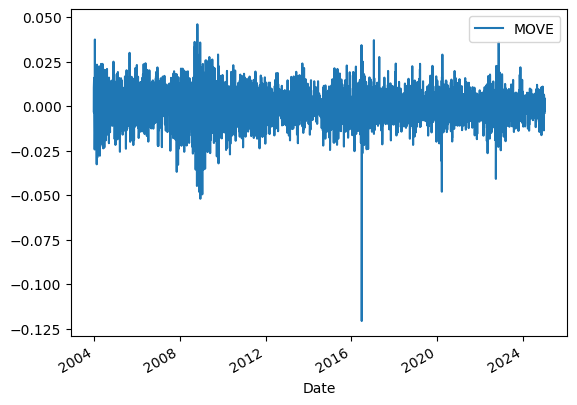

In [3]:
import matplotlib
df_trimmed.plot()

Теперь нам нужно порезать это все на месяцы (чтобы данные одного месяца не сравнивать с данными другого месяца в разные годы, что может случиться за счет разного рода выходных) и сгруппировать по годам:

In [4]:
years = df_trimmed.index.year.unique()
new_index = pd.date_range(start=f'{min(years)}-01-01', end=f'{max(years)}-12-31', freq='D')
df_reindexed = df_trimmed.reindex(new_index).fillna(0.0)
pivot_by_year = df_reindexed.pivot_table(
    index=[df_reindexed.index.month, df_reindexed.index.day],
    columns=df_reindexed.index.year, 
    values='MOVE',
    aggfunc='first').fillna(0.0)  # this fillna is for aligning with leap year
pivot_by_year.head(10)

2004     2005     2006     2007     2008     2009     2010     2011  \
1 1  -0.00289  0.00000  0.00000  0.00041  0.00140  0.00481 -0.00059  0.00000   
  2   0.01033  0.00000  0.00008  0.01466 -0.00526 -0.01245  0.00000  0.00000   
  3   0.00000 -0.01414  0.02322 -0.02237 -0.00975  0.00000  0.00000 -0.01203   
  4   0.00000 -0.02173  0.01240 -0.00849  0.00246  0.00000 -0.00794  0.00965   
  5   0.01342  0.00022 -0.00270 -0.01369  0.00000  0.01540 -0.00920 -0.00707   
  6   0.01489 -0.00744  0.01480  0.00000  0.00000  0.02190  0.00270 -0.00417   
  7  -0.00378 -0.00436  0.00000  0.00000 -0.00341  0.01800 -0.00880  0.00712   
  8   0.01604  0.00000  0.00000  0.00863  0.00310  0.01160  0.00920  0.00000   
  9   0.01389  0.00000 -0.00530  0.00197 -0.01470 -0.00530  0.00000  0.00000   
  10  0.00000  0.00421 -0.00060 -0.00763  0.00300  0.00000  0.00000  0.00285   

         2012     2013  ...     2015     2016     2017     2018     2019  \
1 1   0.00000 -0.00088  ... -0.00029  0.00000  0.00000  0.00000  0.00000   
  2  -0.00284  0.00169  ... -0.02459  0.00000 -0.00655  0.00945 -0.01466   
  3   0.01352 -0.01486  ...  0.00000  0.00000 -0.00384 -0.00747  0.00218   
  4  -0.00274 -0.00382  ...  0.00000 -0.00172  0.00848  0.00362  0.00892   
  5  -0.01261  0.00000  ... -0.00780 -0.00389  0.00939  0.00136  0.00000   
  6  -0.00692  0.00000  ... -0.00970 -0.00436 -0.01349  0.00000  0.00000   
  7   0.00000  0.00465  ... -0.00404 -0.00132  0.00000  0.00000  0.00580   
  8   0.00000 -0.00594  ... -0.00211 -0.00989  0.00000  0.00022 -0.00617   
  9   0.00319 -0.00335  ...  0.00667  0.00000 -0.01217 -0.00267  0.00749   
  10  0.00263  0.01460  ...  0.00000  0.00000  0.00171 -0.00335 -0.00464   

         2020     2021     2022     2023     2024  
1 1   0.00000  0.00000  0.00000  0.00000  0.00000  
  2  -0.01210  0.00000  0.00000 -0.00491 -0.01143  
  3  -0.00562  0.00000 -0.00407 -0.00800  0.00486  
  4   0.00000 -0.00966  0.00504  0.00881  0.00173  
  5   0.00000  0.00595  0.00249 -0.01453  0.00365  
  6   0.00898 -0.00181 -0.00210  0.01803  0.00000  
  7  -0.00496 -0.00467  0.00514  0.00000  0.00000  
  8  -0.00271  0.00010  0.00000  0.00000  0.00296  
  9  -0.00258  0.00000  0.00000  0.00923 -0.00381  
  10 -0.00091  0.00000 -0.00077 -0.00335  0.00331  

[10 rows x 21 columns]

<Axes: >

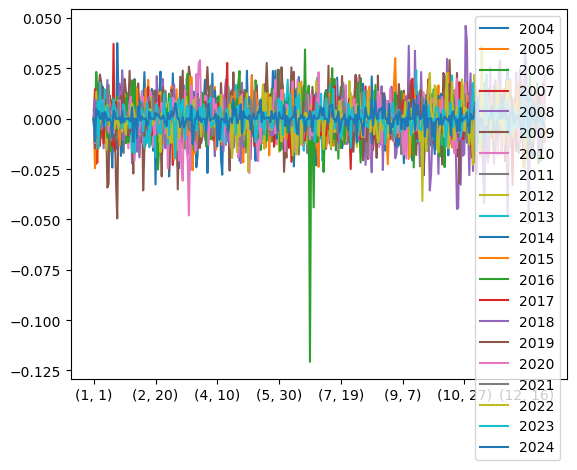

In [5]:
pivot_by_year.plot()

В нашей табличке с пивотом теперь есть колонка с номером месяца и колонка с номером дня месяца - обе входят в индекс - а также колонка для каждого года, в которую записан размер тела свечи с соответствующим знаком в этот день этого месяца этого года.
В целом, данные уже можно проанализировать на корреляцию
Давайте полюбопытствуем


In [6]:
import scipy

correlation_matrix = pivot_by_year.corr().dropna(how='all').dropna(axis=1, how='all')
correlation_matrix.head(50)

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
2004,1.000000,0.075601,0.040341,-0.036041,-0.072639,0.037568,0.059345,-0.027888,0.091461,0.050046,...,0.014497,-0.069409,0.005721,-0.042944,-0.044465,-0.023370,-0.056491,-0.010166,0.083879,0.015565
2005,0.075601,1.000000,0.008521,0.084755,-0.074954,-0.084186,-0.041497,-0.001837,0.033889,-0.053773,...,0.067880,0.065742,-0.090196,-0.017894,-0.017070,0.015238,0.124048,0.003180,-0.025927,0.017259
2006,0.040341,0.008521,1.000000,-0.035595,0.034783,-0.003076,-0.017543,0.026089,0.090185,-0.004068,...,0.054582,-0.007206,0.069114,-0.066171,-0.053876,0.027838,0.023695,0.096060,0.025902,-0.045168
2007,-0.036041,0.084755,-0.035595,1.000000,0.007936,-0.070882,-0.016370,0.028653,-0.024818,0.055396,...,-0.031645,0.014159,-0.033907,0.111127,-0.020882,0.004777,-0.032224,0.036163,0.038346,0.041899
2008,-0.072639,-0.074954,0.034783,0.007936,1.000000,0.028995,0.017260,-0.100557,-0.061370,-0.057682,...,-0.031069,-0.031237,0.042287,0.042632,0.091581,-0.030363,-0.076334,-0.017321,-0.042029,0.129813
2009,0.037568,-0.084186,-0.003076,-0.070882,0.028995,1.000000,-0.013532,-0.017355,0.005850,-0.059013,...,0.027419,0.020029,-0.059978,-0.023107,0.048499,-0.118962,0.004486,-0.030043,-0.015582,0.028279
2010,0.059345,-0.041497,-0.017543,-0.016370,0.017260,-0.013532,1.000000,0.015366,0.023463,0.031852,...,0.004939,0.050245,0.075933,-0.027186,0.040853,0.000511,0.006645,0.049806,0.091875,-0.001569
2011,-0.027888,-0.001837,0.026089,0.028653,-0.100557,-0.017355,0.015366,1.000000,0.033494,0.020221,...,0.019250,0.023854,0.033388,0.046697,-0.053156,0.007467,0.081006,0.025368,0.018554,0.057614
2012,0.091461,0.033889,0.090185,-0.024818,-0.061370,0.005850,0.023463,0.033494,1.000000,0.033655,...,0.046849,0.023681,0.096259,-0.056122,0.006460,-0.060899,-0.014104,0.024776,-0.035605,-0.012677
2013,0.050046,-0.053773,-0.004068,0.055396,-0.057682,-0.059013,0.031852,0.020221,0.033655,1.000000,...,-0.014980,0.008747,-0.056764,-0.066334,0.011430,0.013745,-0.050659,-0.057833,-0.005478,-0.002255


Так, разумеется, ничего не понятно, поэтому мы возьмем верхний треугольник и посчитаем среднюю степень корреляции по годам:

In [7]:
upper_triangle = correlation_matrix.values[np.triu_indices(len(correlation_matrix), k=1)]
average_correlation = np.mean(upper_triangle)
average_correlation

np.float64(0.006010804899502171)

очень близка к нулю, говорит.
Ну мы не удовлетворимся. Обратимся к z-трансформации Фишера, потому что усреднение корреляций - так себе идея

In [8]:
z_values = np.arctanh(upper_triangle)
mean_z = np.mean(z_values)
average_correlation = np.tanh(mean_z)
average_correlation

np.float64(0.006021961292381798)

Еще хуже. Ну окей, на протяжении всего года корреляция стремится к нулю за последние 20 лет
А давайте, может, поищем интервалы внутри года, где она к нулю не стремится?
<b>Сразу предупрежу: в этот момент мы начинаем подыскивать подтверждение нашей исходной теории после того, как она была опровергнута в целом. Это называется подгонка фактов под теорию, в народе известная, как cherry-picking</b>
<br>
Для начала избавимся от понятия месяц и день - ну не нужны они нам объективно. Просто пронумеруем день в году.

In [9]:
len(pivot_by_year)

366

In [10]:
pivot_reset = pivot_by_year.reset_index(drop=True)
pivot_reset.tail(10)

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
356,-0.01108,-0.00773,-0.00369,0.00000,-0.01065,-0.00770,-0.00853,0.00025,0.00000,0.00000,...,-0.00570,-0.00696,-0.00305,0.00000,0.00000,-0.01022,0.00898,-0.00415,0.00058,0.00000
357,0.00693,-0.00357,0.00000,0.00000,-0.00980,-0.00055,0.00427,-0.00918,0.00000,0.00262,...,0.00440,0.00062,0.00000,0.00000,-0.00615,0.01318,0.00582,-0.00038,0.00000,-0.00300
358,0.00010,0.00000,0.00000,-0.00603,0.00020,0.00095,0.00113,0.00000,-0.00460,0.00090,...,0.00314,0.00000,0.00000,0.00758,0.00009,0.00628,-0.00289,0.00000,0.00000,-0.00089
359,0.00000,0.00000,0.01777,0.00129,0.00101,-0.00010,0.00000,0.00000,-0.00009,-0.00131,...,0.00257,0.00000,0.00358,-0.00461,0.00181,-0.00124,0.00000,0.00000,-0.00117,0.00143
360,0.00000,-0.00058,-0.02205,0.00518,-0.01746,0.00000,0.00000,0.00438,0.00146,0.00584,...,0.00000,-0.00066,-0.00166,-0.00227,0.00395,0.00000,0.00000,0.00233,0.00412,-0.00141
361,0.01023,-0.00572,0.00257,0.01230,0.00000,0.00000,-0.00191,0.00409,-0.00394,0.00717,...,0.00000,-0.00144,0.00232,0.00099,0.00836,0.00000,0.00570,-0.00302,0.00731,0.00465
362,-0.00616,-0.01080,0.00685,-0.00021,0.00000,0.00375,-0.00531,-0.02103,0.00658,0.00000,...,-0.00480,-0.00423,0.00417,0.00527,0.00000,-0.00919,-0.00092,-0.00112,-0.00657,0.00000
363,-0.00955,0.00840,-0.00444,0.00000,-0.01665,-0.00970,0.01331,-0.00456,0.00000,0.00000,...,-0.00661,0.00333,0.00562,0.00000,0.00000,0.00499,0.00572,0.00373,-0.00022,0.00000
364,0.00707,-0.00210,0.00000,0.00000,0.00155,0.01760,-0.00732,0.01272,0.00000,0.00190,...,0.00002,0.00828,0.00000,0.00000,0.00360,0.01242,0.00131,0.00407,0.00000,-0.00240
365,-0.00703,0.00000,0.00000,-0.01123,0.02144,0.00888,0.01829,0.00000,0.00840,0.00492,...,-0.00834,0.00000,0.00000,0.00583,0.01441,0.00400,0.00175,0.00000,0.00000,-0.00367


In [11]:
len(pivot_reset)

366

Определим фитнесс-функцию как среднюю корреляцию суб-матрицы с некоторого одного дня по некоторый другой. По Фишеру.

In [12]:
def fitness_function(df, start_index, end_index):
    # Slice the DataFrame based on the given indices
    df_slice = df.iloc[start_index:end_index+1]
    
    # Calculate the correlation matrix
    corr_matrix = df_slice.corr().dropna(how='all').dropna(axis=1, how='all')
    
    # Extract the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.values[np.triu_indices(len(corr_matrix), k=1)]
        # Apply Fisher's z-transformation
    z_values = np.arctanh(upper_triangle)
    
    # Calculate the mean of z-values
    mean_z = np.mean(z_values)
    
    # Transform back to correlation coefficient
    average_corr = np.tanh(mean_z)
    
    return average_corr

Протестируем нашу фитнес-функцию на уже известной величине: средней корреляции от начала и до конца года

In [13]:
fitness_function(pivot_reset, 0, len(pivot_reset))

np.float64(0.006021961292381798)

Совпало, отлично. Давайте накрутим оптимизацию, которая выберет нам оптимальные значения индексов?

In [14]:
import pandas as pd
import numpy as np

def find_optimal_intervals(df, fitness_function):
    n = len(df)
    max_interval_size = n // 2
    best_intervals = []
    best_fitness = 0

    for interval_size in range(2, max_interval_size + 1):
        intervals = []
        for start in range(0, n - interval_size + 1):
            end = start + interval_size - 1
            fitness = fitness_function(df, start, end)
            intervals.append((start, end, fitness))
        
        intervals.sort(key=lambda x: x[2], reverse=True)
        selected = []
        
        for interval in intervals:
            if not any(overlaps(interval, selected_interval) for selected_interval in selected):
                selected.append(interval)
        
        avg_fitness = sum(interval[2] for interval in selected) / len(selected)
        if avg_fitness > best_fitness:
            best_fitness = avg_fitness
            best_intervals = selected

    # Convert the best intervals to a DataFrame
    result_df = pd.DataFrame(best_intervals, columns=['Start', 'End', 'Fitness'])
    result_df['Length'] = result_df['End'] - result_df['Start'] + 1
    result_df = result_df.sort_values('Start').reset_index(drop=True)

    return result_df

def overlaps(interval1, interval2):
    return max(interval1[0], interval2[0]) <= min(interval1[1], interval2[1])

def find_highest_correlation_interval(df, ff, min_interval):
    n = len(df)
    best_start = 0
    best_end = n - 1
    best_correlation = ff(df, best_start, best_end)

    for start in range(n - min_interval):
        for end in range(start + min_interval, n):
            correlation = ff(df, start, end)
            if correlation > best_correlation or np.isnan(best_correlation):
                best_correlation = correlation
                best_start = start
                best_end = end

    return best_start, best_end, best_correlation


Тут, собственно, реализован алгоритм поиска непересекающихся интервалов, жадная вариация.
Он возвращает набор интервалов, отсортированный по убыванию корреляции за все годы.
Натравим его на нашу табличку, попросим :

In [15]:
intervals = find_optimal_intervals(pivot_reset, fitness_function)
# Sort the DataFrame by the 'Fitness' column in descending order
sorted_df = intervals.sort_values('Fitness', ascending=False)
sorted_df.head(10)

,Start,End,Fitness,Length
31,355,362,0.161929,8
20,226,233,0.098708,8
7,82,89,0.086867,8
6,69,76,0.083728,8
1,11,18,0.074793,8
21,235,242,0.067237,8
29,335,342,0.060696,8
25,291,298,0.051251,8
2,26,33,0.048265,8
27,314,321,0.047245,8


In [16]:
best_start, best_end, best_correlation = find_highest_correlation_interval(pivot_reset, fitness_function, 5)
print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

Best interval: [355, 361] with correlation: 0.193341847591015


Неутешительный итог: даже попытки выдать желаемое за действительное не наловили нам ни одного интервала с корреляцией выше 0.21 за последние 20 лет.
Давайте попробуем упростить и забьем на все выходные и прочие нормализации. Просто возьмем последовательности, как они есть.

In [17]:
df_reset_idx = df_trimmed.reset_index()
df_reset_idx['Year'] = df_reset_idx['Date'].dt.year
year_dfs = {year: group['MOVE'].reset_index(drop=True) for year, group in df_reset_idx.groupby('Year')}
df_final = pd.concat(year_dfs, axis=1).fillna(0.0)
df_final.tail(10)

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
256,0.00693,-0.00058,0.01777,-0.01425,-0.05200,-0.01145,-0.00853,0.00025,0.00309,-0.00210,...,-0.00080,-0.00696,0.00094,-0.00294,-0.00140,-0.00534,0.00582,-0.00415,0.00511,-0.00718
257,0.00010,-0.00572,-0.02205,-0.00039,-0.00865,-0.00770,0.00427,-0.00918,-0.01089,-0.00401,...,-0.00570,0.00062,-0.00305,0.00758,-0.00615,-0.01022,-0.00289,-0.00038,0.00058,0.00629
258,0.01023,-0.01080,0.00257,-0.00603,-0.01065,-0.00055,0.00113,0.00438,-0.00460,0.00262,...,0.00440,-0.00066,0.00358,-0.00461,0.00009,0.01318,0.00570,0.00233,-0.00117,-0.00300
259,-0.00616,0.00840,0.00685,0.00129,-0.00980,0.00095,-0.00191,0.00409,-0.00009,0.00090,...,0.00314,-0.00144,-0.00166,-0.00227,0.00181,0.00628,-0.00092,-0.00302,0.00412,-0.00089
260,-0.00955,-0.00210,-0.00444,0.00518,0.00020,-0.00010,-0.00531,-0.02103,0.00146,-0.00131,...,0.00257,-0.00423,0.00232,0.00099,0.00395,-0.00124,0.00572,-0.00112,0.00731,0.00143
261,0.00707,0.00000,0.00000,0.01230,0.00101,0.00375,0.01331,-0.00456,-0.00394,0.00584,...,-0.00480,0.00333,0.00417,0.00527,0.00836,-0.00919,0.00131,0.00373,-0.00657,-0.00141
262,-0.00703,0.00000,0.00000,-0.00021,-0.01746,-0.00970,-0.00732,0.01272,0.00658,0.00717,...,-0.00661,0.00828,0.00562,0.00583,0.00360,0.00499,0.00175,0.00407,-0.00022,0.00465
263,0.00000,0.00000,0.00000,-0.01123,-0.01665,0.01760,0.01829,0.00000,0.00840,0.00190,...,0.00002,0.00000,0.00000,0.00000,0.01441,0.01242,0.00000,0.00000,0.00000,-0.00240
264,0.00000,0.00000,0.00000,0.00000,0.00155,0.00888,0.00000,0.00000,0.00000,0.00492,...,-0.00834,0.00000,0.00000,0.00000,0.00000,0.00400,0.00000,0.00000,0.00000,-0.00367
265,0.00000,0.00000,0.00000,0.00000,0.02144,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


И теперь воспользуемся теми же функциями, которые у нас уже есть

In [18]:
fitness_function(df_final, 0, len(df_final))

np.float64(0.002943085416976744)

In [19]:
best_start, best_end, best_correlation = find_highest_correlation_interval(df_final, fitness_function, 5)
print(f"Best interval: [{best_start}, {best_end}] with correlation: {best_correlation}")

Best interval: [260, 265] with correlation: 1.0


Тут получилось еще хуже, ожидаемо (нули в конце)